# Introduction

### Problem statement

This is a capstone project created as a part of a Nanodegree Data Scientist program. Its goal is to analyze the data for customers of a German mail-order sales company, comparing it with general population of Germanhy, and use the findings to recommend target group for a new marketing campaign and using a dataset with said campaign recipients - predict whether an individual is likely to convert.

Firstly, we need to import libraries and source files. The files are not included with this repository as they take lots of space and the specific terms and conditions forbid further usage and reproduction. They can be currently obtained via kaggle on request, although it cannot be guaranteed in the future. 

In [8]:
# import misc libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import ML libraries
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
# load in the data
azdias = pd.read_csv('dataset/azdias.csv')
customers = pd.read_csv('dataset/customers.csv')
mailout_train = pd.read_csv('dataset/mailout_train.csv')
mailout_test = pd.read_csv('dataset/mailout_test.csv')

C:\Users\JakubBelow\AppData\Local\Temp\ipykernel_24180\3518727280.py:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('dataset/azdias.csv')
C:\Users\JakubBelow\AppData\Local\Temp\ipykernel_24180\3518727280.py:3: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('dataset/customers.csv')
C:\Users\JakubBelow\AppData\Local\Temp\ipykernel_24180\3518727280.py:4: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('dataset/mailout_train.csv')
C:\Users\JakubBelow\AppData\Local\Temp\ipykernel_24180\3518727280.py:5: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('dataset/mailout_test.csv')


# Part 1. Data Exploration

There are four files to consider:

1. **Azdias** file contains demographic data for the general population of Germany with almost 400 features and 900 K entries


2. **Customers** file contains data for existing customers and as such includes additional 3 columns describing the customer:
    - customer group
    - online purchase flag
    - product group


3. **Mailout train** file contains largely the same information but for targets of a marketing campaign


4. **Mailout test** is virtually same as above but for testing purposes only

### Data cleaning

Before clustering customers into segments, we need to investigate several topics and make decisions on how to tackle potential issues:

- datasets shapes and matching columns
- data types
- missing vales in rows and columns
- duplicates

All of the cleaning steps will be performed on the azdias file and once the process is established, repetead on the remaining files.

In [10]:
print(f'Azdias dataset shape: {azdias.shape}\nCustomers dataset shape: {customers.shape}\nMailout train dataset shape: {mailout_train.shape}')

Azdias dataset shape: (891221, 367)
Customers dataset shape: (191652, 370)
Mailout train dataset shape: (42962, 368)


In [11]:
set(customers.columns) - set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [12]:
set(mailout_train.columns) - set(azdias.columns)

{'RESPONSE'}

Datasets are consistent, with differences in features discussed before.

The vast majority of features are numerical with several being incorrectly casted (string instead of float or date).

In [13]:
azdias.dtypes.value_counts()

float64    267
int64       94
object       6
dtype: int64

In [14]:
azdias.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


The three **CAMEO** columns represent an already established stratification of the population by social and economic standing. Since they are partially overlapping, I chose to keep **CAMEO_INTL_2015** as it combines family status with economic class which seems to impact purchasing decisions the most. Don’t get fooled, this is not a numerical feature and we will have to create dummy variables for each unique value. 

**D19_LETZTER_KAUF_BRANCHE** is not explained but "letzter kauf branche" means "last purchase industry" in German and holds 35 unique categories. We will create dummy binary variables for this feature as well.

**PRAEGENDE_JUGENDJAHRE** despite appearing to be ordinal in nature is actually categorical. At first glance we see corresponding values to represent younger generations but after further investigation it turns out they also mix different political orientations.

**EINGEFUEGT_AM** seems to be metadata info on when the record has been inserted and thus is redundant.

Finally, **OST_WEST_KZ** denotes the republic of origin, ost being short for osten (east), so either DDR or FDR. It has to be mapped into binary values.

In [15]:
[col for col in azdias.columns if 'CAMEO' in col]

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

We will also drop the LNR column as it's a unique identifier field and ANREDE_KZ denoting gender.

In [16]:
# check for dups and drop if necessary
azdias['LNR'].duplicated().sum()

0

In [17]:
# drop aforementioned columns alonmg w/ an index column imported from CSV 
cols_to_drop = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'EINGEFUEGT_AM', 'LNR', 'Unnamed: 0']
azdias_clean = azdias.drop(columns=cols_to_drop)
num_cols = azdias_clean.select_dtypes(['float', 'int']).columns
dummy_cols = ['CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'PRAEGENDE_JUGENDJAHRE']

In [18]:
azdias_clean.dtypes.value_counts()

float64    267
int64       92
object       3
dtype: int64

In [19]:
def clean_features(df):
    '''
    Returns given dataframe with transformed features (D19_LETZTER_KAUF_BRANCHE to dummies; OST_WEST_KZ to binary)
    
    INPUT:
     - df (DataFrame): a dataframe with OST_WEST_KZ and D19_LETZTER_KAUF_BRANCHE features to transform
    
    OUTPUT:
     - df (DataFrame): a dataframe with features transformed
    '''
    osten_dict = {'W': 1,
                  'O': 0}
    
    # map OST_WEST_KZ to binary values
    try:
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(osten_dict)
        df.rename(columns = {'OST_WEST_KZ': 'is_osten'}, inplace=True)
        print('Mapped OST_WEST_KZ to binary')
    except:
        print('Error while transforming OST_WEST_KZ')
    
    # create dummy representations of catogorical features and drop the original columnsco
    for col in dummy_cols:
        try:
            new_cols = pd.get_dummies(df[col], prefix=f'{col}_dummy')
            df = pd.concat([df.drop(columns=[col]), new_cols], axis=1)
            print(f'Dummified {col}.')
        except:
            print(f'Error while transforming  {col}')

    return df

In [20]:
azdias_clean = clean_features(azdias_clean)

Mapped OST_WEST_KZ to binary
Dummified CAMEO_INTL_2015.
Dummified D19_LETZTER_KAUF_BRANCHE.
Dummified PRAEGENDE_JUGENDJAHRE.


In [21]:
# make sure we've dealt with dtypes
azdias_clean.dtypes.value_counts()

float64    268
uint8       94
int64       91
dtype: int64

Another important decision to make is which features are carrying enough information, i.e. what is the percentage of missing values. Considering the large number of features and relatively low amount of nulls, we will drop any feature that has less than 85% of values.

In [22]:
nan_pct = round(azdias_clean.isnull().sum() / azdias_clean.shape[0], 2)
nan_pct[nan_pct > 0].sort_values(ascending=False)

ALTER_KIND4          1.00
ALTER_KIND3          0.99
ALTER_KIND2          0.97
ALTER_KIND1          0.91
EXTSEL992            0.73
                     ... 
RT_KEIN_ANREIZ       0.01
RETOURTYP_BK_S       0.01
CJT_KATALOGNUTZER    0.01
CJT_TYP_1            0.01
CJT_TYP_2            0.01
Length: 268, dtype: float64

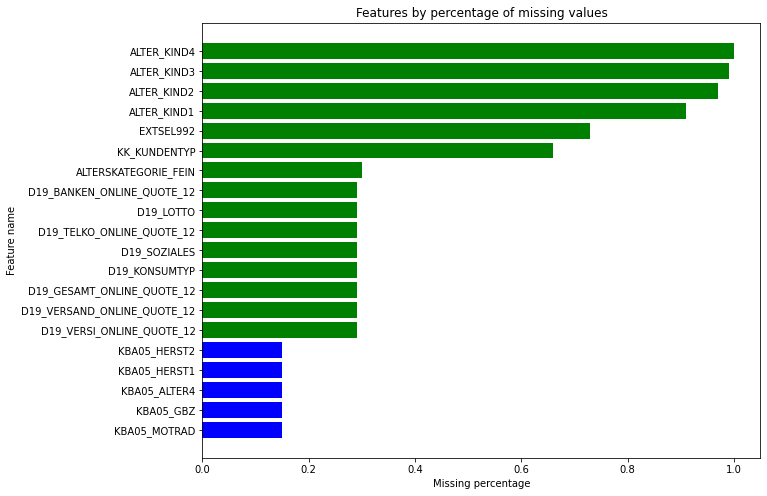

In [23]:
missing_df = pd.DataFrame(nan_pct[nan_pct > 0].sort_values(ascending=False), columns=['missing pct']).sort_values(by='missing pct', ascending=False)[:20]

colors = ['green' if f > .15 else 'blue' for f in missing_df.sort_values(by='missing pct')['missing pct']]

plt.figure(figsize=(10, 8))
plt.title('Features by percentage of missing values')
plt.ylabel('Feature name')
plt.xlabel('Missing percentage')

plt.barh(missing_df.sort_values(by='missing pct').index, missing_df.sort_values(by='missing pct')['missing pct'], color=colors)
plt.show()

In [24]:
missing_cols = list(nan_pct[nan_pct > .15].index)
len(missing_cols)

15

In [25]:
nan_pct.sort_values(ascending=False)[:10]

ALTER_KIND4                    1.00
ALTER_KIND3                    0.99
ALTER_KIND2                    0.97
ALTER_KIND1                    0.91
EXTSEL992                      0.73
KK_KUNDENTYP                   0.66
ALTERSKATEGORIE_FEIN           0.30
D19_GESAMT_ONLINE_QUOTE_12     0.29
D19_VERSAND_ONLINE_QUOTE_12    0.29
D19_BANKEN_ONLINE_QUOTE_12     0.29
dtype: float64

In [26]:
def drop_low_information_cols(df, threshold=.15):
    '''
    Returns given dataframe without columns exceeding set percentage of missing values.
    
    INPUT:
     - df (DataFrame): a dataframe to be transformed
     - threshold (float): a percentage of missing values that's acceptable 
    
    OUTPUT:
     - df (DataFrame): a dataframe with columns exceeding threshold dropped
    '''
    nan_pct = round(df.isnull().sum() / df.shape[0], 2)
    drop_cols = nan_pct <= threshold
    print(f'There are {sum(nan_pct > .15)} columns to be removed')
    print(drop_cols[drop_cols==False])
    df = df.loc[:, drop_cols]
    
    return df

In [27]:
# drop cols with less then 85% values
azdias_clean = drop_low_information_cols(azdias_clean, .15)
cols_to_drop = cols_to_drop + missing_cols
azdias_clean.shape

There are 15 columns to be removed
ALTER_KIND1                    False
ALTER_KIND2                    False
ALTER_KIND3                    False
ALTER_KIND4                    False
ALTERSKATEGORIE_FEIN           False
D19_BANKEN_ONLINE_QUOTE_12     False
D19_GESAMT_ONLINE_QUOTE_12     False
D19_KONSUMTYP                  False
D19_LOTTO                      False
D19_SOZIALES                   False
D19_TELKO_ONLINE_QUOTE_12      False
D19_VERSAND_ONLINE_QUOTE_12    False
D19_VERSI_ONLINE_QUOTE_12      False
EXTSEL992                      False
KK_KUNDENTYP                   False
dtype: bool


(891221, 438)

Now, we can look at the information value of rows and select rows that have enough features for successful prediciton.

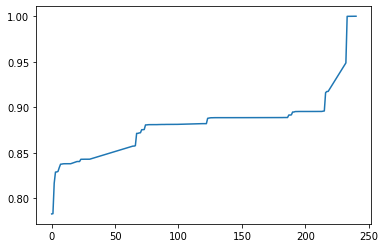

In [28]:
# get the cumulative percentage of rows with increasing count of missing features and plot it for decisionmaking
x = azdias_clean.isnull().sum(axis=1).value_counts().sort_index().cumsum() / azdias_clean.shape[0]
plt.plot(x)

Around 83% of instances have 6 or less missing values. The remaining 17% have between 7 and 240 missing values. The cutoff of 6 missing features seems to be reasonable considering the large quantity of features and records.

In [29]:
x[:10]

0    0.782954
1    0.783197
2    0.816694
3    0.828881
4    0.829042
5    0.829623
6    0.833853
7    0.837516
8    0.837663
9    0.837956
dtype: float64

In [30]:
# drop rows exceeding 3 missing values
azdias_clean = azdias_clean[azdias_clean.isnull().sum(axis=1) <= 6]

Before dealing with the rest of missing values, we want to check how many of the features are binary in nature. These features should exactly two unique values (and we've already dealt with object dtypes).

In [31]:
azdias_clean.shape

(743147, 438)

In [32]:
bin_cols = []

for col in azdias_clean.columns:
    nunique = azdias_clean[col].nunique()
    bin_cols.append(col) if (nunique == 2) else None
    
print(f'There are {len(bin_cols)} binary features')

There are 102 binary features


In [33]:
azdias_clean[bin_cols].describe()

,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KONSUMZELLE,is_osten,SOHO_KZ,UNGLEICHENN_FLAG,ANREDE_KZ,CAMEO_INTL_2015_dummy_12.0,CAMEO_INTL_2015_dummy_13.0,...,PRAEGENDE_JUGENDJAHRE_dummy_6,PRAEGENDE_JUGENDJAHRE_dummy_7,PRAEGENDE_JUGENDJAHRE_dummy_8,PRAEGENDE_JUGENDJAHRE_dummy_9,PRAEGENDE_JUGENDJAHRE_dummy_10,PRAEGENDE_JUGENDJAHRE_dummy_11,PRAEGENDE_JUGENDJAHRE_dummy_12,PRAEGENDE_JUGENDJAHRE_dummy_13,PRAEGENDE_JUGENDJAHRE_dummy_14,PRAEGENDE_JUGENDJAHRE_dummy_15
count,743147.000000,743147.000000,711961.000000,743143.000000,743147.000000,743147.000000,743147.000000,743147.000000,743147.000000,743147.000000,...,743147.000000,743147.000000,743147.000000,743147.000000,743147.000000,743147.000000,743147.000000,743147.000000,743147.000000,743147.000000
mean,0.988983,0.219808,0.089263,0.241044,0.787400,0.008378,0.088077,1.521938,0.006711,0.013682,...,0.033451,0.005146,0.177250,0.042817,0.106123,0.043195,0.030772,0.006808,0.228605,0.051758
std,0.104381,0.414117,0.285124,0.427717,0.409147,0.091147,0.283407,0.499519,0.081643,0.116169,...,0.179811,0.071549,0.381881,0.202443,0.307995,0.203295,0.172699,0.082227,0.419934,0.221539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Apart from dummy values we've just created there are some features with 'flag' in their names and a couple of other columns that appear to be binary. These cannot be treated like other numerical ones when it comes to scaling and filling in null values. Unfortunately, two of these columns contain some nulls.

In [34]:
azdias_clean[bin_cols].loc[:, azdias_clean[bin_cols].isnull().sum() > 0].head(10)

,HH_DELTA_FLAG,KONSUMZELLE
1,0.0,1.0
2,0.0,0.0
3,NaN,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0
10,0.0,0.0


In [35]:
azdias_clean[bin_cols].isnull().sum().sort_values(ascending=False)[:3]

HH_DELTA_FLAG    31186
KONSUMZELLE          4
DSL_FLAG             0
dtype: int64

In this instance, we will fill them with modes as the most prevalent outcome should be typical for demographic data.

In [36]:
# fill the missing vals with mode
azdias_clean[bin_cols] = azdias_clean[bin_cols].fillna(azdias_clean[bin_cols].mode().iloc[0])

In [37]:
azdias_clean[bin_cols].isnull().sum().sort_values(ascending=False)[:3]

DSL_FLAG                                            0
D19_LETZTER_KAUF_BRANCHE_dummy_D19_GARTEN           0
D19_LETZTER_KAUF_BRANCHE_dummy_D19_SAMMELARTIKEL    0
dtype: int64

The rest of missing values will be filled with means.

In [38]:
# fill nans with means and check if any nans left
azdias_clean = azdias_clean.fillna(azdias_clean.mean())
print(f'There are {azdias_clean.isnull().sum().sum()} missing values in the dataframe left and the shape is: {azdias_clean.shape}')

There are 0 missing values in the dataframe left and the shape is: (743147, 438)


As the very last step, we will scale non-binary features.

In [39]:
num_cols = azdias_clean.drop(columns=bin_cols).columns
scaler = StandardScaler()

scaled_cols = pd.DataFrame(scaler.fit_transform(azdias_clean[num_cols]), columns=num_cols)
azdias_scaled = pd.concat([azdias_clean[bin_cols].reset_index(), scaled_cols.reset_index()], axis=1)
azdias_scaled = azdias_scaled.drop(columns=['index'])

And finally, store the outcome for future use.

In [40]:
azdias_scaled.to_csv('dataset/azdias_clean.csv', index=False)

**To sum up**, we performed the following steps:


1. remove redundant categorical features
2. create dummy variables for the remaining categorical feature
3. map object feature to binary data
4. remove features with more than 15% missing values
5. remove all rows with more than 11 missing values [azdias file only]
6. replace missing binary values with modes
7. replace missing numerical features with means
8. check for duplicates


Based on the analysis, we will define a function to perform all the above steps and save the results for convenience.

In [41]:
# customers and mailout train datasets specific columns don't contain any nulls as expected
print(f"Customers-specific columns have {customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].isnull().sum().sum()} missing values and mailout train has also {mailout_train[['RESPONSE']].isnull().sum().sum()}")

Customers-specific columns have 0 missing values and mailout train has also 0


In [44]:
def prepare_dataset(df, cols_to_drop, bin_cols):
    '''
    Returns cleaned dataframe after performing all the cleaning steps outlined in the analysis.
    
    INPUT:
     - df (DataFrame): a dataframe with OST_WEST_KZ and D19_LETZTER_KAUF_BRANCHE features to transform
     - cols_to_drop (list): a list of columns to be dropped as per previous analysis
     - bin_cols (list): a list of binary columns to be inputed with modes
    
    OUTPUT:
     - df (DataFrame): a dataframe with features transformed
    '''
    
    print('Cleaning the dataset')
    
    # drop redundant columns
    cleaned_df = df.drop(columns=cols_to_drop)
    
    # clean binary and dummy features
    cleaned_df = clean_features(cleaned_df)
    
    # fill binary nans with modes
    print('Imputing binary Nans with modes...')
    cleaned_df[bin_cols] = cleaned_df[bin_cols].fillna(cleaned_df[bin_cols].mode().iloc[0])
    
    # fill remaining nans with columns' means
    print('Imputing numerical Nans with means...')
    
    num_cols = cleaned_df.drop(columns=bin_cols).columns
    cleaned_df[num_cols] = cleaned_df[num_cols].fillna(cleaned_df[num_cols].mean())
    
    # scale numerical features
    print('Scaling numerical features...')
    scaler = StandardScaler()
    scaled_cols = pd.DataFrame(scaler.fit_transform(cleaned_df[num_cols]), columns=num_cols)
    scaled_df = pd.concat([cleaned_df[bin_cols].reset_index(), scaled_cols.reset_index()], axis=1)
    
    # drop redundant index
    scaled_df = scaled_df.drop(columns=['index'])
    
    return cleaned_df


In [45]:
# pre-process customers dataset accordingly, remembering about the three additional columns that need to be omitted
customers_scaled = prepare_dataset(customers, cols_to_drop=cols_to_drop, bin_cols=bin_cols+['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])
customers_scaled.to_csv('dataset/customers_clean.csv', index=False)

Cleaning the dataset
Mapped OST_WEST_KZ to binary
Dummified CAMEO_INTL_2015.
Dummified D19_LETZTER_KAUF_BRANCHE.
Dummified PRAEGENDE_JUGENDJAHRE.
Imputing binary Nans with modes...
Imputing numerical Nans with means...
Scaling numerical features...


In [46]:
# pre-process mailout train dataset accordingly, remembering about the additional column that needs to be omitted
mailout_train_scaled = prepare_dataset(mailout_train, cols_to_drop=cols_to_drop, bin_cols=bin_cols+['RESPONSE'])
mailout_train_scaled.to_csv('dataset/mailout_train_clean.csv', index=False)

Cleaning the dataset
Mapped OST_WEST_KZ to binary
Dummified CAMEO_INTL_2015.
Dummified D19_LETZTER_KAUF_BRANCHE.
Dummified PRAEGENDE_JUGENDJAHRE.
Imputing binary Nans with modes...
Imputing numerical Nans with means...
Scaling numerical features...


In [47]:
# pre-process mailout test dataset accordingly
mailout_test_scaled = prepare_dataset(mailout_test, cols_to_drop=cols_to_drop, bin_cols=bin_cols)
mailout_test_scaled.to_csv('dataset/mailout_test_clean.csv', index=False)

Cleaning the dataset
Mapped OST_WEST_KZ to binary
Dummified CAMEO_INTL_2015.
Dummified D19_LETZTER_KAUF_BRANCHE.
Dummified PRAEGENDE_JUGENDJAHRE.
Imputing binary Nans with modes...
Imputing numerical Nans with means...
Scaling numerical features...


We have three cleaned datasets now with almost the same features, except for a couple of customer-specific and campaign-specific ones.

In [48]:
set(customers_scaled.columns) - set(azdias_scaled.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [49]:
set(mailout_train_scaled.columns) - set(azdias_scaled.columns)

{'RESPONSE'}

In [50]:
customers.shape

(191652, 370)

The next part of the project includes dimentionality reduction and clusterization. These steps are tackled in the 2_customer_segmentation file.